# Use this to evaluate our Mask R-CNN model

In [19]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import mammo_ddsm
import mammo_baseline
import mammo

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "mammography", "checkpoints")

# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/mammo")

In [2]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

## Configurations

In [3]:
# # Inference Configuration
config = mammo_ddsm.MammoInferenceConfig()
# config.display()

## Notebook Preferences

In [4]:
DEVICE = "/gpu:0"  #
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [6]:
dataset = mammo_ddsm.MammoDataset()
# dataset.load_mammo(DATASET_DIR, "mass_test", augmented=False)
dataset.load_mammo(DATASET_DIR, "mass_test", augmented=False, json_filename="mammo_ddsm_test.json")
# dataset.load_mammo(DATASET_DIR, "calc_test", augmented=False, json_filename="mammo_ddsm_calc_test.json")
dataset.prepare()

# Load validation dataset
# dataset = mammo_ddsm.MammoDataset()
# dataset.load_mammo(DATASET_DIR, "mass_test", augmented=False, json_filename="mammo_ddsm_test.json")
# dataset.load_mammo(DATASET_DIR, "calc_test", augmented=False, json_filename="mammo_ddsm_calc_test.json")
# dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

mass_test
Images: 361
Classes: ['BG', 'MALIGNANT', 'BENIGN']


## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

## Run Detection

Image ID: 76
image ID: ddsm.P_01640_LEFT_MLO (76) None
Original image shape:  [1024  488    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detections: (1, 100, 6)
mrcnn_mask: (1, 100, 28, 28, 3)
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  360.00000  max:  676.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
GT match [2.]
Pred match [-1. -1.  0. -1. -1.]
Precision 1: [0.         0.         0.33333333 0.25       0.2       ]
Recall 1: [0. 0. 1. 1. 1.]
mAP 0.3333333333333333
A

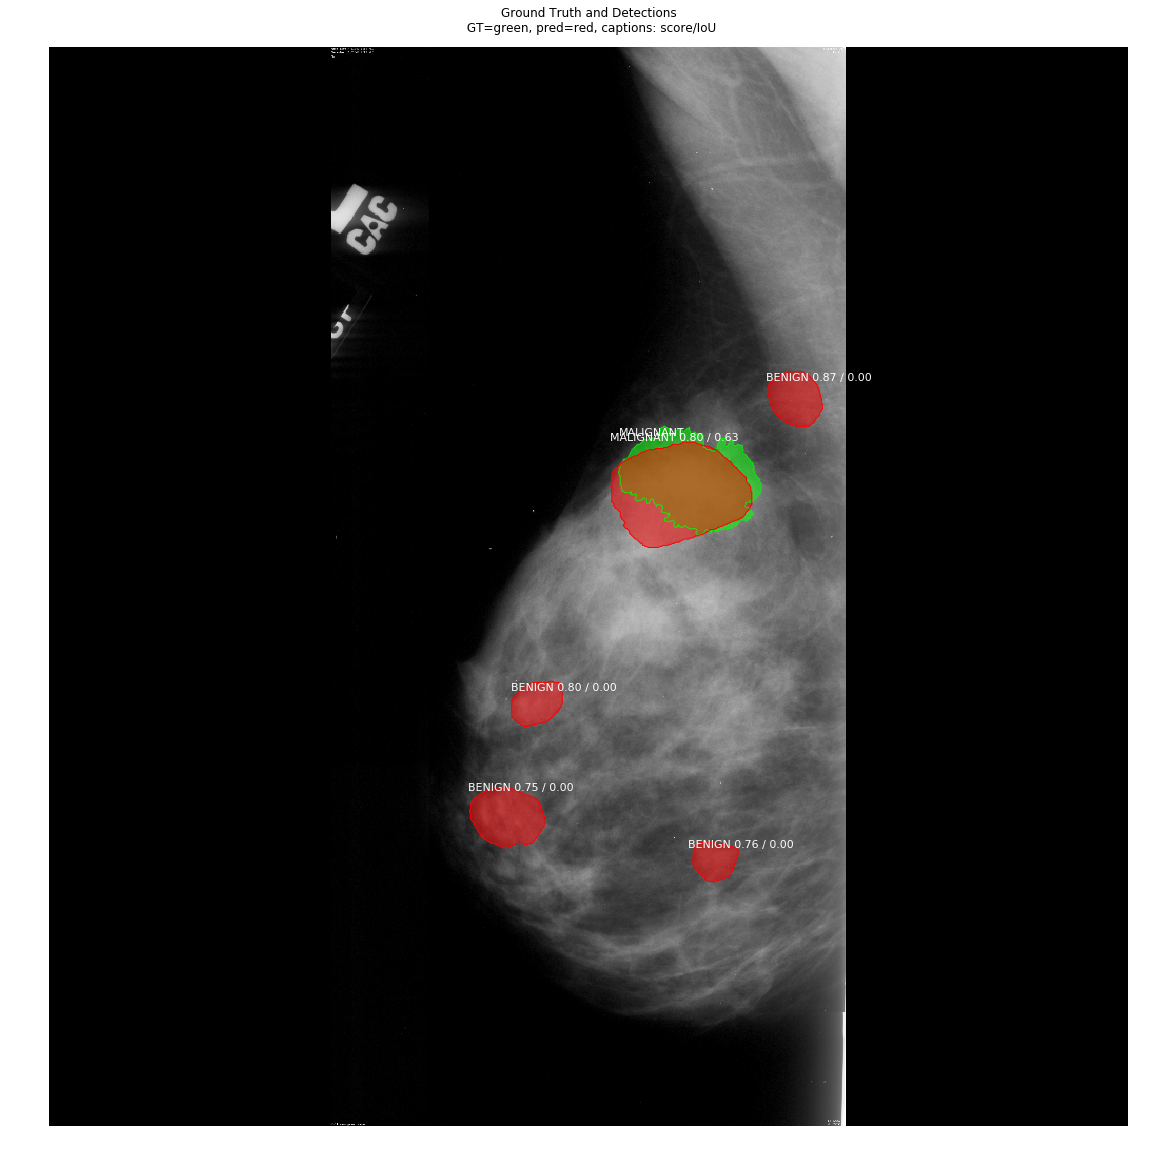

In [25]:
image_id = random.choice(dataset.image_ids)
# image_id = 343
print("Image ID:", image_id)
_25aug_1024reso_3x_3class = "mammo20180824T1833"
n_epochs = "mask_rcnn_mammo_000" + str(5) + ".h5"
weights_path = os.path.join(LOGS_DIR, _25aug_1024reso_3x_3class, n_epochs)

# print("\n", i, ": Loading weights ", weights_path)
# time_now = time.time()
model.load_weights(weights_path, by_name=True) 


image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# # Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# # Compute AP over range 0.5 to 0.95 and print it
mAP, AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

# print(AP)
print(gt_class_id)
print(r['class_ids'])

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=True,
    iou_threshold=0.5, score_threshold=0.9)

In [7]:
class ResizeConfig(mammo_baseline.MammoConfig):
#     BACKBONE = "resnet101"
    BACKBONE = "resnet101"
#     IMAGE_RESIZE_MODE = "none"
#     USE_MINI_MASK = False
    # Adjust depending on your GPU memory
#     IMAGES_PER_GPU = 1
#     IMAGE_MAX_DIM = 1408
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    IMAGE_MAX_DIM = 1024

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + mass

    # Number of training and validation steps per epoch
#     STEPS_PER_EPOCH = (len(dataset_train.image_ids) - len(dataset_val.image_ids)) // IMAGES_PER_GPU
#     STEPS_PER_EPOCH = (len(dataset_train.image_ids)) // IMAGES_PER_GPU
#     VALIDATION_STEPS = max(1, len(dataset_val.image_ids) // IMAGES_PER_GPU)
    
#     MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
#     RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
#     RPN_TRAIN_ANCHORS_PER_IMAGE = 512
#     RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    
#     # ROIs kept after non-maximum supression (training and inference)
#     POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000
    
#     # Non-max suppression threshold to filter RPN proposals.
#     # You can increase this during training to generate more propsals.
#     RPN_NMS_THRESHOLD = 0.7
    
config = ResizeConfig()
# config.display()

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [ ]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
_1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf = "mammo20180901T1321"
_2sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf_512rpn = "mammo20180902T0159"
_3sep_1024_reso_mass_train_3x_base_gpu2img_roi_inf_512rpn_112mask = "mammo20180902T1432"
_3sep_1024_reso_mass_train_fastrcnn = "mammo20180903T2151"
_4sep_1024_reso_mass_train_3x_fastrcnn = "mammo20180904T0233"
latest = _4sep_1024_reso_mass_train_3x_fastrcnn 

epochs_trained = 11
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], 
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set

In [36]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
_1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf = "mammo20180901T1321"
_2sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf_512rpn = "mammo20180902T0159"
_3sep_1024_reso_mass_train_3x_base_gpu2img_roi_inf_512rpn_112mask = "mammo20180902T1432"
_3sep_1024_reso_mass_train_fastrcnn = "mammo20180903T2151"
latest = _3sep_1024_reso_mass_train_fastrcnn 

epochs_trained = 11
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], 
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(3, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180903T2151\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.395
AP @0.55:	 0.366
AP @0.60:	 0.306
AP @0.65:	 0.236
AP @0.70:	 0.193
AP @0.75:	 0.111
AP @0.80:	 0.054
AP @0.85:	 0.014
AP @0.90:	 0.003
AP @0.95:	 0.003
Mean AP over 361 images: 0.1682
Time taken: 111.33705973625183

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180903T2151\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.535
AP @0.55:	 0.469
AP @0.60:	 0.412
AP @0.65:	 0.336
AP @0.70:	 0.242
AP @0.75:	 0.172
AP @0.80:	 0.101
AP @0.85:	 0.050
AP @0.90:	 0.012
AP @0.95:	 0.000
Mean AP over 361 images: 0.2329
Time taken: 118.46000003814697

 5 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180903T2151\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.517
AP @0.55:	 0.463
AP @0.60:	 0.419
AP @0.65:	 0.347
AP @0.70:	 0.265
AP @0.75:	 0.183
AP @0.80:	 0.078
AP @

In [14]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
_1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf = "mammo20180901T1321"
_2sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf_512rpn = "mammo20180902T0159"
_3sep_1024_reso_mass_train_3x_base_gpu2img_roi_inf_512rpn_112mask = "mammo20180902T1432"
latest = _3sep_1024_reso_mass_train_3x_base_gpu2img_roi_inf_512rpn_112mask 

epochs_trained = 11
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T1432\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.525
AP @0.55:	 0.500
AP @0.60:	 0.443
AP @0.65:	 0.373
AP @0.70:	 0.315
AP @0.75:	 0.217
AP @0.80:	 0.116
AP @0.85:	 0.021
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2514
Time taken: 575.9577512741089

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T1432\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.568
AP @0.55:	 0.529
AP @0.60:	 0.451
AP @0.65:	 0.398
AP @0.70:	 0.321
AP @0.75:	 0.216
AP @0.80:	 0.138
AP @0.85:	 0.067
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2691
Time taken: 463.3819122314453

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T1432\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.536
AP @0.55:	 0.492
AP @0.60:	 0.438
AP @0.65:	 0.373
AP @0.70:	 0.303
AP @0.75:	 0.182
AP @0.80:	 0.112
AP @0.

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
_1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf = "mammo20180901T1321"
_2sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf_512rpn = "mammo20180902T0159"
latest = _2sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf_512rpn 

epochs_trained = 11
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T0159\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.566
AP @0.55:	 0.519
AP @0.60:	 0.450
AP @0.65:	 0.369
AP @0.70:	 0.282
AP @0.75:	 0.189
AP @0.80:	 0.103
AP @0.85:	 0.022
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2504
Time taken: 452.2659044265747

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T0159\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.613
AP @0.55:	 0.567
AP @0.60:	 0.529
AP @0.65:	 0.467
AP @0.70:	 0.357
AP @0.75:	 0.254
AP @0.80:	 0.133
AP @0.85:	 0.048
AP @0.90:	 0.008
AP @0.95:	 0.000
Mean AP over 361 images: 0.2975
Time taken: 402.4202470779419

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180902T0159\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.623
AP @0.55:	 0.577
AP @0.60:	 0.518
AP @0.65:	 0.454
AP @0.70:	 0.373
AP @0.75:	 0.254
AP @0.80:	 0.134
AP @0.

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
_1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf = "mammo20180901T1321"
latest = _1sep_1024_reso_mass_train_3x_baseline_gpu2img_roi_inf

epochs_trained = 11
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T1321\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.434
AP @0.55:	 0.401
AP @0.60:	 0.366
AP @0.65:	 0.295
AP @0.70:	 0.223
AP @0.75:	 0.160
AP @0.80:	 0.087
AP @0.85:	 0.028
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.1996
Time taken: 517.8975138664246

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T1321\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.595
AP @0.55:	 0.543
AP @0.60:	 0.459
AP @0.65:	 0.381
AP @0.70:	 0.298
AP @0.75:	 0.202
AP @0.80:	 0.098
AP @0.85:	 0.033
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2608
Time taken: 315.3865964412689

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T1321\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.637
AP @0.55:	 0.598
AP @0.60:	 0.543
AP @0.65:	 0.451
AP @0.70:	 0.346
AP @0.75:	 0.243
AP @0.80:	 0.133
AP @0.

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
_1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf = "mammo20180901T0310"
latest = _1sep_1024_reso_mass_train_baseline_gpu2img_roi_inf

epochs_trained = 16
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(7, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 7 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T0310\mask_rcnn_mammo_0007.h5
AP @0.50:	 0.548
AP @0.55:	 0.511
AP @0.60:	 0.443
AP @0.65:	 0.374
AP @0.70:	 0.291
AP @0.75:	 0.198
AP @0.80:	 0.089
AP @0.85:	 0.028
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2482
Time taken: 399.0893440246582

 8 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T0310\mask_rcnn_mammo_0008.h5
AP @0.50:	 0.587
AP @0.55:	 0.521
AP @0.60:	 0.443
AP @0.65:	 0.355
AP @0.70:	 0.270
AP @0.75:	 0.196
AP @0.80:	 0.090
AP @0.85:	 0.029
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2491
Time taken: 320.44204926490784

 9 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180901T0310\mask_rcnn_mammo_0009.h5
AP @0.50:	 0.611
AP @0.55:	 0.568
AP @0.60:	 0.526
AP @0.65:	 0.469
AP @0.70:	 0.372
AP @0.75:	 0.248
AP @0.80:	 0.149
AP @0

In [14]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
latest = _31aug_1024_reso_mass_train_baseline_gpu2img

epochs_trained = 16
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(4, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.503
AP @0.55:	 0.457
AP @0.60:	 0.403
AP @0.65:	 0.312
AP @0.70:	 0.256
AP @0.75:	 0.174
AP @0.80:	 0.091
AP @0.85:	 0.025
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2220
Time taken: 421.01718163490295

 5 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.608
AP @0.55:	 0.562
AP @0.60:	 0.484
AP @0.65:	 0.401
AP @0.70:	 0.301
AP @0.75:	 0.202
AP @0.80:	 0.104
AP @0.85:	 0.027
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2688
Time taken: 434.10153222084045

 6 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0006.h5
AP @0.50:	 0.580
AP @0.55:	 0.537
AP @0.60:	 0.490
AP @0.65:	 0.418
AP @0.70:	 0.325
AP @0.75:	 0.224
AP @0.80:	 0.139
AP @

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
_31aug_1024_reso_mass_train_baseline_gpu2img = "mammo20180831T1605"
latest = _31aug_1024_reso_mass_train_baseline_gpu2img

epochs_trained = 16
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.420
AP @0.55:	 0.370
AP @0.60:	 0.313
AP @0.65:	 0.256
AP @0.70:	 0.166
AP @0.75:	 0.063
AP @0.80:	 0.019
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1609
Time taken: 420.3900010585785

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.429
AP @0.55:	 0.372
AP @0.60:	 0.334
AP @0.65:	 0.286
AP @0.70:	 0.201
AP @0.75:	 0.144
AP @0.80:	 0.071
AP @0.85:	 0.017
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1854
Time taken: 276.813059091568

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180831T1605\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.501
AP @0.55:	 0.451
AP @0.60:	 0.399
AP @0.65:	 0.308
AP @0.70:	 0.254
AP @0.75:	 0.175
AP @0.80:	 0.091
AP @0.8

In [21]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
_31aug_1024_reso_mass_train_baseline = "mammo20180830T2353"
latest = _31aug_1024_reso_mass_train_baseline

epochs_trained = 21
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180830T2353\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.405
AP @0.55:	 0.369
AP @0.60:	 0.327
AP @0.65:	 0.288
AP @0.70:	 0.195
AP @0.75:	 0.128
AP @0.80:	 0.057
AP @0.85:	 0.014
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1782
Time taken: 325.358163356781

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180830T2353\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.459
AP @0.55:	 0.421
AP @0.60:	 0.372
AP @0.65:	 0.315
AP @0.70:	 0.249
AP @0.75:	 0.173
AP @0.80:	 0.066
AP @0.85:	 0.025
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2080
Time taken: 242.77277493476868

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180830T2353\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.547
AP @0.55:	 0.507
AP @0.60:	 0.460
AP @0.65:	 0.406
AP @0.70:	 0.312
AP @0.75:	 0.207
AP @0.80:	 0.112
AP @0.

In [12]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
_30aug_1408_reso_mass_train_3x_augmentation_all_2nd = "mammo20180830T1217"
latest = _30aug_1408_reso_mass_train_3x_augmentation_all_2nd

epochs_trained = 6
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(4, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180830T1217\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.499
AP @0.55:	 0.467
AP @0.60:	 0.408
AP @0.65:	 0.334
AP @0.70:	 0.283
AP @0.75:	 0.189
AP @0.80:	 0.104
AP @0.85:	 0.032
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2316
Time taken: 575.4780647754669

 5 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180830T1217\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.557
AP @0.55:	 0.522
AP @0.60:	 0.465
AP @0.65:	 0.395
AP @0.70:	 0.332
AP @0.75:	 0.234
AP @0.80:	 0.132
AP @0.85:	 0.054
AP @0.90:	 0.011
AP @0.95:	 0.000
Mean AP over 361 images: 0.2703
Time taken: 582.2348728179932


In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
_30aug_1408_reso_mass_train_3x_augmentation_all = "mammo20180829T1701"
latest = _30aug_1408_reso_mass_train_3x_augmentation_all

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180829T1701\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.321
AP @0.55:	 0.286
AP @0.60:	 0.234
AP @0.65:	 0.195
AP @0.70:	 0.149
AP @0.75:	 0.080
AP @0.80:	 0.037
AP @0.85:	 0.009
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1311
Time taken: 606.4934813976288

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180829T1701\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.598
AP @0.55:	 0.547
AP @0.60:	 0.508
AP @0.65:	 0.437
AP @0.70:	 0.345
AP @0.75:	 0.228
AP @0.80:	 0.137
AP @0.85:	 0.046
AP @0.90:	 0.008
AP @0.95:	 0.000
Mean AP over 361 images: 0.2855
Time taken: 599.4386084079742

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180829T1701\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.576
AP @0.55:	 0.516
AP @0.60:	 0.481
AP @0.65:	 0.418
AP @0.70:	 0.329
AP @0.75:	 0.224
AP @0.80:	 0.127
AP @0.

In [10]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
_29aug_1408_reso_mass_train_3x_augmentation = "mammo20180828T2233"
latest = _29aug_1408_reso_mass_train_3x_augmentation

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T2233\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.434
AP @0.55:	 0.402
AP @0.60:	 0.343
AP @0.65:	 0.280
AP @0.70:	 0.229
AP @0.75:	 0.147
AP @0.80:	 0.080
AP @0.85:	 0.019
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1935
Time taken: 665.6094722747803

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T2233\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.503
AP @0.55:	 0.460
AP @0.60:	 0.407
AP @0.65:	 0.352
AP @0.70:	 0.262
AP @0.75:	 0.151
AP @0.80:	 0.074
AP @0.85:	 0.020
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2229
Time taken: 611.297333240509

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T2233\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.714
AP @0.55:	 0.628
AP @0.60:	 0.540
AP @0.65:	 0.477
AP @0.70:	 0.369
AP @0.75:	 0.256
AP @0.80:	 0.146
AP @0.8

In [9]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
_28aug_1024_reso_mass_train_resnet50_1x = "mammo20180828T1129"
latest = _28aug_1024_reso_mass_train_resnet50_1x

epochs_trained = 10
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T1129\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.019
AP @0.55:	 0.016
AP @0.60:	 0.010
AP @0.65:	 0.004
AP @0.70:	 0.004
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0052
Time taken: 568.5076801776886

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T1129\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.073
AP @0.55:	 0.058
AP @0.60:	 0.037
AP @0.65:	 0.024
AP @0.70:	 0.018
AP @0.75:	 0.012
AP @0.80:	 0.003
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0229
Time taken: 425.99500608444214

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180828T1129\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.030
AP @0.55:	 0.019
AP @0.60:	 0.015
AP @0.65:	 0.006
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0

In [10]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
_27aug_1024_reso_calc_train_3x = "mammo20180827T1306"
latest = _27aug_1024_reso_calc_train_3x

epochs_trained = 15
limit = 282

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180827T1306\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 282 images: 0.0000
Time taken: 345.43274116516113

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180827T1306\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.052
AP @0.55:	 0.032
AP @0.60:	 0.027
AP @0.65:	 0.025
AP @0.70:	 0.017
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 282 images: 0.0152
Time taken: 432.4055771827698

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180827T1306\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.079
AP @0.55:	 0.067
AP @0.60:	 0.052
AP @0.65:	 0.036
AP @0.70:	 0.018
AP @0.75:	 0.014
AP @0.80:	 0.000
AP @0

KeyboardInterrupt: 

In [10]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
_26aug_1024reso_calc_train_1x = "mammo20180826T2121"
latest = _26aug_1024reso_calc_train_1x

epochs_trained = 20
limit = 282

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180826T2121\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.005
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 282 images: 0.0005
Time taken: 497.7316610813141

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180826T2121\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.035
AP @0.55:	 0.018
AP @0.60:	 0.010
AP @0.65:	 0.003
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 282 images: 0.0066
Time taken: 387.1407837867737

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180826T2121\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.020
AP @0.55:	 0.015
AP @0.60:	 0.010
AP @0.65:	 0.008
AP @0.70:	 0.005
AP @0.75:	 0.001
AP @0.80:	 0.000
AP @0.

In [21]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
_25aug_1024reso_3x_3class = "mammo20180824T1833"
latest = _25aug_1024reso_3x_3class

epochs_trained = 10
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180824T1833\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.181
AP @0.55:	 0.168
AP @0.60:	 0.140
AP @0.65:	 0.111
AP @0.70:	 0.078
AP @0.75:	 0.047
AP @0.80:	 0.021
AP @0.85:	 0.006
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0752
Time taken: 514.0298092365265

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180824T1833\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.290
AP @0.55:	 0.262
AP @0.60:	 0.225
AP @0.65:	 0.186
AP @0.70:	 0.136
AP @0.75:	 0.089
AP @0.80:	 0.043
AP @0.85:	 0.006
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1236
Time taken: 577.1221525669098

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180824T1833\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.270
AP @0.55:	 0.243
AP @0.60:	 0.207
AP @0.65:	 0.167
AP @0.70:	 0.123
AP @0.75:	 0.074
AP @0.80:	 0.035
AP @0.

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
_24aug_high_reso_3x_aug_lrud = "mammo20180823T2037"
latest = _24aug_high_reso_3x_aug_lrud

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180823T2037\mask_rcnn_mammo_0001.h5


ValueError: Dimension 1 in both shapes must be equal, but are 12 and 8 for 'Assign_682' (op: 'Assign') with input shapes: [1024,12], [1024,8].

In [10]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
_23aug_high_reso_3x_augmentation = "mammo20180822T2348"
latest = _23aug_high_reso_3x_augmentation

epochs_trained = 10
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T2348\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.451
AP @0.55:	 0.404
AP @0.60:	 0.364
AP @0.65:	 0.296
AP @0.70:	 0.248
AP @0.75:	 0.164
AP @0.80:	 0.089
AP @0.85:	 0.029
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2048
Time taken: 771.065176486969

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T2348\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.608
AP @0.55:	 0.553
AP @0.60:	 0.502
AP @0.65:	 0.433
AP @0.70:	 0.329
AP @0.75:	 0.222
AP @0.80:	 0.127
AP @0.85:	 0.033
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2807
Time taken: 795.0168371200562

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T2348\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.512
AP @0.55:	 0.474
AP @0.60:	 0.433
AP @0.65:	 0.390
AP @0.70:	 0.306
AP @0.75:	 0.213
AP @0.80:	 0.127
AP @0.8

In [11]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (1x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
_22aug_high_reso_fix = "mammo20180822T0411"
latest = _22aug_high_reso_fix

epochs_trained = 20
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T0411\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.343
AP @0.55:	 0.310
AP @0.60:	 0.253
AP @0.65:	 0.201
AP @0.70:	 0.154
AP @0.75:	 0.082
AP @0.80:	 0.036
AP @0.85:	 0.005
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1383
Time taken: 1590.9803528785706

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T0411\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.373
AP @0.55:	 0.334
AP @0.60:	 0.280
AP @0.65:	 0.230
AP @0.70:	 0.151
AP @0.75:	 0.114
AP @0.80:	 0.059
AP @0.85:	 0.024
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1565
Time taken: 848.7831380367279

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180822T0411\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.449
AP @0.55:	 0.403
AP @0.60:	 0.350
AP @0.65:	 0.315
AP @0.70:	 0.250
AP @0.75:	 0.169
AP @0.80:	 0.100
AP @0

In [26]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
latest = _21aug_high_reso_3x_fix

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.632
AP @0.55:	 0.583
AP @0.60:	 0.525
AP @0.65:	 0.446
AP @0.70:	 0.363
AP @0.75:	 0.259
AP @0.80:	 0.151
AP @0.85:	 0.065
AP @0.90:	 0.011
AP @0.95:	 0.000
Mean AP over 361 images: 0.3036
Time taken: 1262.071620941162

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.644
AP @0.55:	 0.597
AP @0.60:	 0.535
AP @0.65:	 0.446
AP @0.70:	 0.336
AP @0.75:	 0.231
AP @0.80:	 0.138
AP @0.85:	 0.040
AP @0.90:	 0.001
AP @0.95:	 0.000
Mean AP over 361 images: 0.2968
Time taken: 788.5282146930695

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.659
AP @0.55:	 0.611
AP @0.60:	 0.529
AP @0.65:	 0.401
AP @0.70:	 0.334
AP @0.75:	 0.219
AP @0.80:	 0.115
AP @0.

In [22]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
latest = _21aug_high_reso_3x_fix

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.544
AP @0.55:	 0.441
AP @0.60:	 0.361
AP @0.65:	 0.250
AP @0.70:	 0.123
AP @0.75:	 0.051
AP @0.80:	 0.015
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1787
Time taken: 1234.6664378643036

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.530
AP @0.55:	 0.433
AP @0.60:	 0.339
AP @0.65:	 0.210
AP @0.70:	 0.105
AP @0.75:	 0.038
AP @0.80:	 0.009
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1664
Time taken: 785.9589097499847

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.537
AP @0.55:	 0.409
AP @0.60:	 0.306
AP @0.65:	 0.177
AP @0.70:	 0.067
AP @0.75:	 0.026
AP @0.80:	 0.003
AP @0

In [10]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
_18aug = "mammo20180818T0049"
_19aug_high_reso = "mammo20180819T0021"
_20aug_high_reso_3x = "mammo20180819T2347"
_21aug_high_reso_3x_fix = "mammo20180821T0232"
latest = _21aug_high_reso_3x_fix

epochs_trained = 9
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.541
AP @0.55:	 0.500
AP @0.60:	 0.435
AP @0.65:	 0.356
AP @0.70:	 0.280
AP @0.75:	 0.169
AP @0.80:	 0.070
AP @0.85:	 0.022
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2373
Time taken: 705.4512748718262

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.539
AP @0.55:	 0.504
AP @0.60:	 0.460
AP @0.65:	 0.424
AP @0.70:	 0.346
AP @0.75:	 0.252
AP @0.80:	 0.143
AP @0.85:	 0.053
AP @0.90:	 0.006
AP @0.95:	 0.000
Mean AP over 361 images: 0.2727
Time taken: 583.4534244537354

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.678
AP @0.55:	 0.601
AP @0.60:	 0.539
AP @0.65:	 0.465
AP @0.70:	 0.385
AP @0.75:	 0.277
AP @0.80:	 0.158
AP @0.

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
_17aug = "mammo20180816T2351"
latest = _17aug

epochs_trained = 20
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T2351\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.505
AP @0.55:	 0.460
AP @0.60:	 0.395
AP @0.65:	 0.321
AP @0.70:	 0.213
AP @0.75:	 0.152
AP @0.80:	 0.080
AP @0.85:	 0.028
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2155
Time taken: 604.5182657241821

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T2351\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.653
AP @0.55:	 0.600
AP @0.60:	 0.525
AP @0.65:	 0.460
AP @0.70:	 0.358
AP @0.75:	 0.252
AP @0.80:	 0.137
AP @0.85:	 0.044
AP @0.90:	 0.009
AP @0.95:	 0.000
Mean AP over 361 images: 0.3038
Time taken: 611.1289811134338

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T2351\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.563
AP @0.55:	 0.538
AP @0.60:	 0.473
AP @0.65:	 0.412
AP @0.70:	 0.343
AP @0.75:	 0.251
AP @0.80:	 0.147
AP @0.

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
_16aug = "mammo20180816T0050"
latest = _16aug

epochs_trained = 19
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T0050\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.537
AP @0.55:	 0.492
AP @0.60:	 0.429
AP @0.65:	 0.369
AP @0.70:	 0.268
AP @0.75:	 0.134
AP @0.80:	 0.056
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2286
Time taken: 1023.3377158641815

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T0050\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.656
AP @0.55:	 0.583
AP @0.60:	 0.507
AP @0.65:	 0.420
AP @0.70:	 0.328
AP @0.75:	 0.209
AP @0.80:	 0.103
AP @0.85:	 0.032
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2840
Time taken: 675.7031345367432

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180816T0050\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.633
AP @0.55:	 0.579
AP @0.60:	 0.527
AP @0.65:	 0.443
AP @0.70:	 0.341
AP @0.75:	 0.227
AP @0.80:	 0.145
AP @0

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
_15aug = "mammo20180814T1848"
latest = _15aug

epochs_trained = 14
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T1848\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.221
AP @0.55:	 0.179
AP @0.60:	 0.133
AP @0.65:	 0.093
AP @0.70:	 0.053
AP @0.75:	 0.034
AP @0.80:	 0.016
AP @0.85:	 0.005
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0734
Time taken: 1489.9738276004791

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T1848\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.491
AP @0.55:	 0.429
AP @0.60:	 0.375
AP @0.65:	 0.311
AP @0.70:	 0.247
AP @0.75:	 0.151
AP @0.80:	 0.061
AP @0.85:	 0.024
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2092
Time taken: 1034.1504950523376

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T1848\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.572
AP @0.55:	 0.512
AP @0.60:	 0.453
AP @0.65:	 0.379
AP @0.70:	 0.298
AP @0.75:	 0.197
AP @0.80:	 0.082
AP @

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
_14aug = "mammo20180814T0051"
latest = _14aug

epochs_trained = 14
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        
# Run on validation set


 1 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T0051\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.149
AP @0.55:	 0.125
AP @0.60:	 0.100
AP @0.65:	 0.068
AP @0.70:	 0.045
AP @0.75:	 0.013
AP @0.80:	 0.003
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0504
Time taken: 1374.1270439624786

 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T0051\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.225
AP @0.55:	 0.192
AP @0.60:	 0.169
AP @0.65:	 0.127
AP @0.70:	 0.092
AP @0.75:	 0.060
AP @0.80:	 0.038
AP @0.85:	 0.012
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0915
Time taken: 1211.0770347118378

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180814T0051\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.326
AP @0.55:	 0.297
AP @0.60:	 0.260
AP @0.65:	 0.204
AP @0.70:	 0.148
AP @0.75:	 0.097
AP @0.80:	 0.060
AP @

In [11]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
_13aug = "mammo20180813T1321"
latest = _13aug

epochs_trained = 10
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180813T1321\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.099
AP @0.55:	 0.074
AP @0.60:	 0.050
AP @0.65:	 0.032
AP @0.70:	 0.017
AP @0.75:	 0.007
AP @0.80:	 0.003
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0282
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180813T1321\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.167
AP @0.55:	 0.120
AP @0.60:	 0.091
AP @0.65:	 0.060
AP @0.70:	 0.037
AP @0.75:	 0.020
AP @0.80:	 0.013
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0511
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180813T1321\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.221
AP @0.55:	 0.189
AP @0.60:	 0.142
AP @0.65:	 0.105
AP @0.70:	 0.066
AP @0.75:	 0.045
AP @0.80:	 0.010
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.0778
L

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"
_12aug = "mammo20180812T0235"
latest = _12aug

epochs_trained = 26
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180812T0235\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.452
AP @0.55:	 0.384
AP @0.60:	 0.340
AP @0.65:	 0.274
AP @0.70:	 0.198
AP @0.75:	 0.123
AP @0.80:	 0.062
AP @0.85:	 0.026
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1859
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180812T0235\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.532
AP @0.55:	 0.500
AP @0.60:	 0.440
AP @0.65:	 0.383
AP @0.70:	 0.323
AP @0.75:	 0.190
AP @0.80:	 0.123
AP @0.85:	 0.041
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2535
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180812T0235\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.588
AP @0.55:	 0.518
AP @0.60:	 0.453
AP @0.65:	 0.373
AP @0.70:	 0.291
AP @0.75:	 0.208
AP @0.80:	 0.116
AP @0.85:	 0.027
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2574
L

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"
_10aug = "mammo20180810T0325"

epochs_trained = 25
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _10aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _10aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180810T0325\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.275
AP @0.55:	 0.226
AP @0.60:	 0.185
AP @0.65:	 0.120
AP @0.70:	 0.091
AP @0.75:	 0.048
AP @0.80:	 0.018
AP @0.85:	 0.005
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.0970
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180810T0325\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.562
AP @0.55:	 0.506
AP @0.60:	 0.441
AP @0.65:	 0.380
AP @0.70:	 0.295
AP @0.75:	 0.211
AP @0.80:	 0.124
AP @0.85:	 0.046
AP @0.90:	 0.001
AP @0.95:	 0.000
Mean AP over 361 images: 0.2566
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180810T0325\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.607
AP @0.55:	 0.590
AP @0.60:	 0.520
AP @0.65:	 0.462
AP @0.70:	 0.384
AP @0.75:	 0.272
AP @0.80:	 0.152
AP @0.85:	 0.075
AP @0.90:	 0.012
AP @0.95:	 0.000
Mean AP over 361 images: 0.3076
L

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"
_8aug = "mammo20180807T1402"

epochs_trained = 16
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _8aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _8aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180807T1402\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.398
AP @0.55:	 0.362
AP @0.60:	 0.316
AP @0.65:	 0.252
AP @0.70:	 0.188
AP @0.75:	 0.119
AP @0.80:	 0.067
AP @0.85:	 0.025
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.1731
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180807T1402\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.574
AP @0.55:	 0.537
AP @0.60:	 0.491
AP @0.65:	 0.425
AP @0.70:	 0.333
AP @0.75:	 0.227
AP @0.80:	 0.116
AP @0.85:	 0.032
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2736
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180807T1402\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.625
AP @0.55:	 0.579
AP @0.60:	 0.524
AP @0.65:	 0.437
AP @0.70:	 0.353
AP @0.75:	 0.235
AP @0.80:	 0.117
AP @0.85:	 0.044
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2917
L

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"
_6aug = "mammo20180806T0203"

epochs_trained = 17
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _6aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _6aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180806T0203\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.418
AP @0.55:	 0.343
AP @0.60:	 0.267
AP @0.65:	 0.169
AP @0.70:	 0.110
AP @0.75:	 0.053
AP @0.80:	 0.018
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1381
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180806T0203\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.558
AP @0.55:	 0.484
AP @0.60:	 0.387
AP @0.65:	 0.286
AP @0.70:	 0.190
AP @0.75:	 0.112
AP @0.80:	 0.066
AP @0.85:	 0.006
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2089
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180806T0203\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.612
AP @0.55:	 0.544
AP @0.60:	 0.469
AP @0.65:	 0.385
AP @0.70:	 0.248
AP @0.75:	 0.165
AP @0.80:	 0.067
AP @0.85:	 0.011
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2503
L

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"

epochs_trained = 20
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _5aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _5aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.613
AP @0.55:	 0.562
AP @0.60:	 0.495
AP @0.65:	 0.411
AP @0.70:	 0.318
AP @0.75:	 0.218
AP @0.80:	 0.102
AP @0.85:	 0.017
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2735
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.604
AP @0.55:	 0.553
AP @0.60:	 0.499
AP @0.65:	 0.431
AP @0.70:	 0.347
AP @0.75:	 0.249
AP @0.80:	 0.136
AP @0.85:	 0.044
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2866
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.640
AP @0.55:	 0.585
AP @0.60:	 0.515
AP @0.65:	 0.430
AP @0.70:	 0.333
AP @0.75:	 0.227
AP @0.80:	 0.142
AP @0.85:	 0.038
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2913
L

OSError: Unable to open file (Unable to open file: name = 'c:\users\chevy\documents\github\mammo_maskrcnn\mammography\checkpoints\mammo20180803t0316\mask_rcnn_mammo_0013.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"
_4aug = "mammo20180802T0059"
_5aug = "mammo20180803T0316"

epochs_trained = 12
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _5aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _5aug, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.613
AP @0.55:	 0.562
AP @0.60:	 0.495
AP @0.65:	 0.411
AP @0.70:	 0.318
AP @0.75:	 0.218
AP @0.80:	 0.102
AP @0.85:	 0.017
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2735
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.604
AP @0.55:	 0.553
AP @0.60:	 0.499
AP @0.65:	 0.431
AP @0.70:	 0.347
AP @0.75:	 0.249
AP @0.80:	 0.136
AP @0.85:	 0.044
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2866
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180803T0316\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.640
AP @0.55:	 0.585
AP @0.60:	 0.515
AP @0.65:	 0.430
AP @0.70:	 0.333
AP @0.75:	 0.227
AP @0.80:	 0.142
AP @0.85:	 0.038
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2913
L

In [16]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _29jul, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _29jul, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180729T0221\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.348
AP @0.55:	 0.320
AP @0.60:	 0.258
AP @0.65:	 0.215
AP @0.70:	 0.172
AP @0.75:	 0.096
AP @0.80:	 0.031
AP @0.85:	 0.003
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1443
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180729T0221\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.591
AP @0.55:	 0.544
AP @0.60:	 0.477
AP @0.65:	 0.418
AP @0.70:	 0.319
AP @0.75:	 0.217
AP @0.80:	 0.129
AP @0.85:	 0.039
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2738
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180729T0221\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.559
AP @0.55:	 0.504
AP @0.60:	 0.455
AP @0.65:	 0.394
AP @0.70:	 0.313
AP @0.75:	 0.229
AP @0.80:	 0.119
AP @0.85:	 0.042
AP @0.90:	 0.001
AP @0.95:	 0.000
Mean AP over 361 images: 0.2615
L

OSError: Unable to open file (Unable to open file: name = 'c:\users\chevy\documents\github\mammo_maskrcnn\mammography\checkpoints\mammo20180729t0221\mask_rcnn_mammo_0022.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [17]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"
_29jul = "mammo20180729T0221"
_30jul = "mammo20180730T0235"

epochs_trained = 21
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(1, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _30jul, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, _30jul, n_epochs)
        
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180730T0235\mask_rcnn_mammo_0001.h5
AP @0.50:	 0.523
AP @0.55:	 0.469
AP @0.60:	 0.403
AP @0.65:	 0.333
AP @0.70:	 0.242
AP @0.75:	 0.157
AP @0.80:	 0.090
AP @0.85:	 0.026
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2243
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180730T0235\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.569
AP @0.55:	 0.540
AP @0.60:	 0.493
AP @0.65:	 0.436
AP @0.70:	 0.349
AP @0.75:	 0.243
AP @0.80:	 0.135
AP @0.85:	 0.047
AP @0.90:	 0.006
AP @0.95:	 0.000
Mean AP over 361 images: 0.2819
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180730T0235\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.654
AP @0.55:	 0.603
AP @0.60:	 0.567
AP @0.65:	 0.495
AP @0.70:	 0.400
AP @0.75:	 0.259
AP @0.80:	 0.151
AP @0.85:	 0.058
AP @0.90:	 0.006
AP @0.95:	 0.000
Mean AP over 361 images: 0.3192
L

## Results from non-augmented images

In [8]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"
latest = "mammo20180725T1413"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(5, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.458
AP @0.55:	 0.404
AP @0.60:	 0.349
AP @0.65:	 0.283
AP @0.70:	 0.207
AP @0.75:	 0.146
AP @0.80:	 0.075
AP @0.85:	 0.015
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.1941
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0006.h5
AP @0.50:	 0.495
AP @0.55:	 0.419
AP @0.60:	 0.346
AP @0.65:	 0.262
AP @0.70:	 0.182
AP @0.75:	 0.119
AP @0.80:	 0.064
AP @0.85:	 0.008
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1896
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0007.h5
AP @0.50:	 0.554
AP @0.55:	 0.511
AP @0.60:	 0.444
AP @0.65:	 0.375
AP @0.70:	 0.288
AP @0.75:	 0.178
AP @0.80:	 0.100
AP @0.85:	 0.042
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2492
L

AP @0.50:	 0.575
AP @0.55:	 0.506
AP @0.60:	 0.447
AP @0.65:	 0.380
AP @0.70:	 0.298
AP @0.75:	 0.195
AP @0.80:	 0.094
AP @0.85:	 0.036
AP @0.90:	 0.006
AP @0.95:	 0.000
Mean AP over 361 images: 0.2538
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0031.h5
AP @0.50:	 0.486
AP @0.55:	 0.449
AP @0.60:	 0.396
AP @0.65:	 0.314
AP @0.70:	 0.231
AP @0.75:	 0.171
AP @0.80:	 0.082
AP @0.85:	 0.027
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.2156
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0032.h5
AP @0.50:	 0.578
AP @0.55:	 0.524
AP @0.60:	 0.484
AP @0.65:	 0.389
AP @0.70:	 0.286
AP @0.75:	 0.177
AP @0.80:	 0.105
AP @0.85:	 0.035
AP @0.90:	 0.010
AP @0.95:	 0.000
Mean AP over 361 images: 0.2588
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180725T1413\mask_rcnn_mammo_0033.h5
A

In [29]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"

epochs_trained = 38
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(5, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.573
AP @0.55:	 0.536
AP @0.60:	 0.480
AP @0.65:	 0.427
AP @0.70:	 0.322
AP @0.75:	 0.198
AP @0.80:	 0.122
AP @0.85:	 0.044
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 10 images: 0.2705
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0006.h5
AP @0.50:	 0.523
AP @0.55:	 0.478
AP @0.60:	 0.397
AP @0.65:	 0.299
AP @0.70:	 0.226
AP @0.75:	 0.148
AP @0.80:	 0.072
AP @0.85:	 0.012
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 10 images: 0.2155
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0007.h5
AP @0.50:	 0.580
AP @0.55:	 0.528
AP @0.60:	 0.489
AP @0.65:	 0.419
AP @0.70:	 0.324
AP @0.75:	 0.235
AP @0.80:	 0.120
AP @0.85:	 0.053
AP @0.90:	 0.009
AP @0.95:	 0.000
Mean AP over 10 images: 0.2756
Load

AP @0.50:	 0.589
AP @0.55:	 0.549
AP @0.60:	 0.487
AP @0.65:	 0.408
AP @0.70:	 0.328
AP @0.75:	 0.232
AP @0.80:	 0.118
AP @0.85:	 0.036
AP @0.90:	 0.006
AP @0.95:	 0.000
Mean AP over 10 images: 0.2753
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0031.h5
AP @0.50:	 0.566
AP @0.55:	 0.504
AP @0.60:	 0.443
AP @0.65:	 0.386
AP @0.70:	 0.294
AP @0.75:	 0.202
AP @0.80:	 0.108
AP @0.85:	 0.034
AP @0.90:	 0.012
AP @0.95:	 0.000
Mean AP over 10 images: 0.2549
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0032.h5
AP @0.50:	 0.580
AP @0.55:	 0.527
AP @0.60:	 0.469
AP @0.65:	 0.409
AP @0.70:	 0.324
AP @0.75:	 0.183
AP @0.80:	 0.125
AP @0.85:	 0.030
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 10 images: 0.2650
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0033.h5
AP @

In [30]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"

epochs_trained = 50
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(5, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, first, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, first, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.559
AP @0.55:	 0.525
AP @0.60:	 0.480
AP @0.65:	 0.413
AP @0.70:	 0.328
AP @0.75:	 0.220
AP @0.80:	 0.113
AP @0.85:	 0.034
AP @0.90:	 0.008
AP @0.95:	 0.000
Mean AP over 361 images: 0.2679
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0006.h5
AP @0.50:	 0.593
AP @0.55:	 0.536
AP @0.60:	 0.495
AP @0.65:	 0.424
AP @0.70:	 0.336
AP @0.75:	 0.211
AP @0.80:	 0.116
AP @0.85:	 0.051
AP @0.90:	 0.011
AP @0.95:	 0.000
Mean AP over 361 images: 0.2773
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0007.h5
AP @0.50:	 0.599
AP @0.55:	 0.544
AP @0.60:	 0.509
AP @0.65:	 0.448
AP @0.70:	 0.368
AP @0.75:	 0.249
AP @0.80:	 0.138
AP @0.85:	 0.041
AP @0.90:	 0.011
AP @0.95:	 0.000
Mean AP over 361 images: 0.2907
L

AP @0.50:	 0.473
AP @0.55:	 0.423
AP @0.60:	 0.381
AP @0.65:	 0.324
AP @0.70:	 0.273
AP @0.75:	 0.172
AP @0.80:	 0.093
AP @0.85:	 0.020
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2161
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0031.h5
AP @0.50:	 0.517
AP @0.55:	 0.469
AP @0.60:	 0.426
AP @0.65:	 0.386
AP @0.70:	 0.294
AP @0.75:	 0.200
AP @0.80:	 0.103
AP @0.85:	 0.046
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2446
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0032.h5
AP @0.50:	 0.387
AP @0.55:	 0.361
AP @0.60:	 0.325
AP @0.65:	 0.249
AP @0.70:	 0.204
AP @0.75:	 0.154
AP @0.80:	 0.086
AP @0.85:	 0.028
AP @0.90:	 0.000
AP @0.95:	 0.000
Mean AP over 361 images: 0.1794
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T2144\mask_rcnn_mammo_0033.h5
A

KeyboardInterrupt: 

In [31]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"

epochs_trained = 25
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
#             print("{:3} {}   AP: {:.2f}".format(
#                 meta["image_id"][0], meta["original_image_shape"][0], AP))
    return mAPs,APs

iou_range = np.arange(0.5, 1.0, 0.05)

for i in range(5, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, second, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, second, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180716T2155\mask_rcnn_mammo_0005.h5
AP @0.50:	 0.538
AP @0.55:	 0.490
AP @0.60:	 0.444
AP @0.65:	 0.393
AP @0.70:	 0.314
AP @0.75:	 0.203
AP @0.80:	 0.123
AP @0.85:	 0.035
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2544
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180716T2155\mask_rcnn_mammo_0006.h5
AP @0.50:	 0.574
AP @0.55:	 0.527
AP @0.60:	 0.458
AP @0.65:	 0.391
AP @0.70:	 0.305
AP @0.75:	 0.221
AP @0.80:	 0.094
AP @0.85:	 0.024
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2597
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180716T2155\mask_rcnn_mammo_0007.h5
AP @0.50:	 0.540
AP @0.55:	 0.508
AP @0.60:	 0.454
AP @0.65:	 0.386
AP @0.70:	 0.327
AP @0.75:	 0.219
AP @0.80:	 0.108
AP @0.85:	 0.039
AP @0.90:	 0.003
AP @0.95:	 0.000
Mean AP over 361 images: 0.2585
L

### 24th June and before

In [9]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
seventh = "mammo20180723T1241"

epochs_trained = 38
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, seventh, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, seventh, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0110
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0419
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1094
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.0307
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.0292
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T1241\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.0550
Loading weights 

In [10]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"
sixth = "mammo20180723T0300"
seventh = "mammo20180723T1241"

epochs_trained = 45
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, sixth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, sixth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0773
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.1091
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.0801
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1718
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.0942
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180723T0300\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.0807
Loading weights 

KeyboardInterrupt: 

In [14]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(10, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, pre, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0010.h5
Mean AP overa 361 images: 0.2230
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0011.h5
Mean AP overa 361 images: 0.2077
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0012.h5
Mean AP overa 361 images: 0.2797
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0013.h5
Mean AP overa 361 images: 0.2775
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0014.h5
Mean AP overa 361 images: 0.2810
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180715T0134\mask_rcnn_mammo_0015.h5
Mean AP overa 361 images: 0.2353
Loading weights 

In [16]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, fourth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, fourth, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0982
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0957
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1661
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1284
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.1969
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180720T0204\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.1908
Loading weights 

In [17]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"
pre = "mammo20180715T0134"
first = "mammo20180715T2144"
second = "mammo20180716T2155"
third = "mammo20180718T0053"
fourth = "mammo20180720T0204"

epochs_trained = 40
limit = 361

def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

for i in range(2, epochs_trained+1):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, third, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True) 
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, third, n_epochs)
        print("Loading weights ", weights_path)
        model.load_weights(weights_path, by_name=True)       
        APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
        
# Run on validation set

Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0002.h5
Mean AP overa 361 images: 0.0650
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0003.h5
Mean AP overa 361 images: 0.0745
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0004.h5
Mean AP overa 361 images: 0.1105
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0005.h5
Mean AP overa 361 images: 0.1942
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0006.h5
Mean AP overa 361 images: 0.2181
Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180718T0053\mask_rcnn_mammo_0007.h5
Mean AP overa 361 images: 0.1912
Loading weights 

In [33]:
## Pre with 20 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.10
  2 [1024  555    3]   AP: 0.80
  3 [1024  576    3]   AP: 0.50
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.10
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.03
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.30
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.15
 12 [1024  649    3]   AP: 0.40
 13 [1024  712    3]   AP: 0.07
 14 [1024  642    3]   AP: 0.00
 15 [1024  700    3]   AP: 0.40
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.80
 18 [1024  453    3]   AP: 0.15
 19 [1024  486    3]   AP: 0.30
 20 [1024  707    3]   AP: 0.60
 21 [1024  710    3]   AP: 0.20
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.10
 24 [1024  673    3]   AP: 0.70
 25 [1024  602    3]   AP: 0.80
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.05
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.30
258 [1024  500    3]   AP: 0.80
259 [1024  673    3]   AP: 0.03
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.50
264 [1024  552    3]   AP: 0.07
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.10
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.60
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.30
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.10
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.20
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.60
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [31]:
## Pre with 20 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.20
  1 [1024  375    3]   AP: 0.13
  2 [1024  555    3]   AP: 0.40
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.10
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.02
  8 [1024  699    3]   AP: 0.40
  9 [1024  501    3]   AP: 0.30
 10 [1024  454    3]   AP: 0.20
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.60
 13 [1024  712    3]   AP: 0.17
 14 [1024  642    3]   AP: 0.05
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.70
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.30
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.10
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.20
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.30
259 [1024  673    3]   AP: 0.05
260 [1024  669    3]   AP: 0.10
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.05
263 [1024  516    3]   AP: 0.30
264 [1024  552    3]   AP: 0.12
265 [1024  688    3]   AP: 0.20
266 [1024  546    3]   AP: 0.20
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.20
269 [1024  590    3]   AP: 0.20
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.05
272 [1024  734    3]   AP: 0.05
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.20
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.13
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.20
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.06
288 [102

In [29]:
## Pre with 25 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.50
  1 [1024  375    3]   AP: 0.00
  2 [1024  555    3]   AP: 0.70
  3 [1024  576    3]   AP: 0.70
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.20
  6 [1024  652    3]   AP: 0.10
  7 [1024  646    3]   AP: 0.05
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.25
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.15
 12 [1024  649    3]   AP: 0.20
 13 [1024  712    3]   AP: 0.00
 14 [1024  642    3]   AP: 0.10
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.50
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.50
 20 [1024  707    3]   AP: 0.60
 21 [1024  710    3]   AP: 0.30
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.60
 25 [1024  602    3]   AP: 0.70
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.70
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.04
265 [1024  688    3]   AP: 0.20
266 [1024  546    3]   AP: 0.10
267 [1024  521    3]   AP: 0.60
268 [1024  566    3]   AP: 0.05
269 [1024  590    3]   AP: 0.30
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.40
276 [1024  675    3]   AP: 0.80
277 [1024  677    3]   AP: 0.10
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.10
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [27]:
## Pre with 30 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.40
  1 [1024  375    3]   AP: 0.03
  2 [1024  555    3]   AP: 0.50
  3 [1024  576    3]   AP: 0.30
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.20
  6 [1024  652    3]   AP: 0.10
  7 [1024  646    3]   AP: 0.07
  8 [1024  699    3]   AP: 0.15
  9 [1024  501    3]   AP: 0.60
 10 [1024  454    3]   AP: 0.10
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.70
 13 [1024  712    3]   AP: 0.07
 14 [1024  642    3]   AP: 0.15
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.70
 17 [1024  512    3]   AP: 0.30
 18 [1024  453    3]   AP: 0.60
 19 [1024  486    3]   AP: 0.60
 20 [1024  707    3]   AP: 0.90
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.40
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.30
 25 [1024  602    3]   AP: 0.30
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.10
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.25
259 [1024  673    3]   AP: 0.05
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.10
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.15
265 [1024  688    3]   AP: 0.06
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.60
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.20
272 [1024  734    3]   AP: 0.10
273 [1024  641    3]   AP: 0.10
274 [1024  644    3]   AP: 0.05
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.20
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.50
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [25]:
## Pre with 35 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.15
  2 [1024  555    3]   AP: 0.50
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.05
  6 [1024  652    3]   AP: 0.03
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.40
  9 [1024  501    3]   AP: 0.50
 10 [1024  454    3]   AP: 0.03
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.50
 13 [1024  712    3]   AP: 0.10
 14 [1024  642    3]   AP: 0.07
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.70
 19 [1024  486    3]   AP: 0.50
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.20
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.07
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.35
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.10
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.08
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.05
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.60
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.03
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.40
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.60
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.20
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

In [23]:
### Pre with 40 epochs
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.30
  1 [1024  375    3]   AP: 0.00
  2 [1024  555    3]   AP: 0.30
  3 [1024  576    3]   AP: 0.60
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.50
  9 [1024  501    3]   AP: 0.23
 10 [1024  454    3]   AP: 0.10
 11 [1024  685    3]   AP: 0.60
 12 [1024  649    3]   AP: 0.70
 13 [1024  712    3]   AP: 0.20
 14 [1024  642    3]   AP: 0.15
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.40
 18 [1024  453    3]   AP: 0.60
 19 [1024  486    3]   AP: 0.70
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.40
 25 [1024  602    3]   AP: 0.40
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.35
258 [1024  500    3]   AP: 0.30
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.40
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.00
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.70
276 [1024  675    3]   AP: 0.70
277 [1024  677    3]   AP: 0.03
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.40
280 [1024  628    3]   AP: 0.70
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.40
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## Fourth Training results on Mass-Test

In [11]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.951
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.40
  1 [1024  375    3]   AP: 0.30
  2 [1024  555    3]   AP: 0.00
  3 [1024  576    3]   AP: 0.00
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.20
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.40
 13 [1024  712    3]   AP: 0.03
 14 [1024  642    3]   AP: 0.00
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.00
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.00
 19 [1024  486    3]   AP: 0.00
 20 [1024  707    3]   AP: 0.90
 21 [1024  710    3]   AP: 0.50
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.50
 25 [1024  602    3]   AP: 0.60
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.00
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.30
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.50
267 [1024  521    3]   AP: 0.00
268 [1024  566    3]   AP: 0.10
269 [1024  590    3]   AP: 0.40
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.30
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.70
279 [1024  581    3]   AP: 0.00
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.80
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.30
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## Third training results on Mass-Test

In [15]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.40
  2 [1024  555    3]   AP: 0.00
  3 [1024  576    3]   AP: 0.00
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.05
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.50
 12 [1024  649    3]   AP: 0.00
 13 [1024  712    3]   AP: 0.05
 14 [1024  642    3]   AP: 0.10
 15 [1024  700    3]   AP: 0.60
 16 [1024  713    3]   AP: 0.50
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.00
 19 [1024  486    3]   AP: 0.40
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.40
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.30
 25 [1024  602    3]   AP: 0.30
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.80
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.20
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.30
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.30
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.10
275 [1024  667    3]   AP: 0.35
276 [1024  675    3]   AP: 0.50
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.50
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.70
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.20
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

## First results on Mass-Train

In [18]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 361
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024  471    3]   AP: 0.60
  1 [1024  375    3]   AP: 0.50
  2 [1024  555    3]   AP: 0.60
  3 [1024  576    3]   AP: 0.50
  4 [1024  528    3]   AP: 0.00
  5 [1024  525    3]   AP: 0.00
  6 [1024  652    3]   AP: 0.00
  7 [1024  646    3]   AP: 0.00
  8 [1024  699    3]   AP: 0.00
  9 [1024  501    3]   AP: 0.00
 10 [1024  454    3]   AP: 0.00
 11 [1024  685    3]   AP: 0.40
 12 [1024  649    3]   AP: 0.30
 13 [1024  712    3]   AP: 0.15
 14 [1024  642    3]   AP: 0.05
 15 [1024  700    3]   AP: 0.50
 16 [1024  713    3]   AP: 0.60
 17 [1024  512    3]   AP: 0.60
 18 [1024  453    3]   AP: 0.50
 19 [1024  486    3]   AP: 0.15
 20 [1024  707    3]   AP: 0.80
 21 [1024  710    3]   AP: 0.30
 22 [1024  417    3]   AP: 0.00
 23 [1024  504    3]   AP: 0.00
 24 [1024  673    3]   AP: 0.60
 25 [1024  602    3]   AP: 0.70
 26 [1024  655    3]   AP: 0.00
 27 [1024  635    3]   AP: 0.00
 28 [1024  735    3]   AP: 0.00
 29 [1024  533    3]   AP: 0.00
 30 [1024  559    3]   AP: 0.00
 31 [102

257 [1024  533    3]   AP: 0.60
258 [1024  500    3]   AP: 0.70
259 [1024  673    3]   AP: 0.00
260 [1024  669    3]   AP: 0.00
261 [1024  458    3]   AP: 0.00
262 [1024  387    3]   AP: 0.00
263 [1024  516    3]   AP: 0.00
264 [1024  552    3]   AP: 0.00
265 [1024  688    3]   AP: 0.00
266 [1024  546    3]   AP: 0.07
267 [1024  521    3]   AP: 0.70
268 [1024  566    3]   AP: 0.00
269 [1024  590    3]   AP: 0.25
270 [1024  593    3]   AP: 0.00
271 [1024  743    3]   AP: 0.00
272 [1024  734    3]   AP: 0.00
273 [1024  641    3]   AP: 0.00
274 [1024  644    3]   AP: 0.00
275 [1024  667    3]   AP: 0.50
276 [1024  675    3]   AP: 0.60
277 [1024  677    3]   AP: 0.00
278 [1024  700    3]   AP: 0.80
279 [1024  581    3]   AP: 0.30
280 [1024  628    3]   AP: 0.00
281 [1024  681    3]   AP: 0.50
282 [1024  576    3]   AP: 0.00
283 [1024  587    3]   AP: 0.00
284 [1024  512    3]   AP: 0.00
285 [1024  501    3]   AP: 0.00
286 [1024  536    3]   AP: 0.00
287 [1024  554    3]   AP: 0.00
288 [102

image ID: ddsm.P_01414_RIGHT_MLO (238) None
Original image shape:  [1024  476    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  440.00000  max:  662.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000


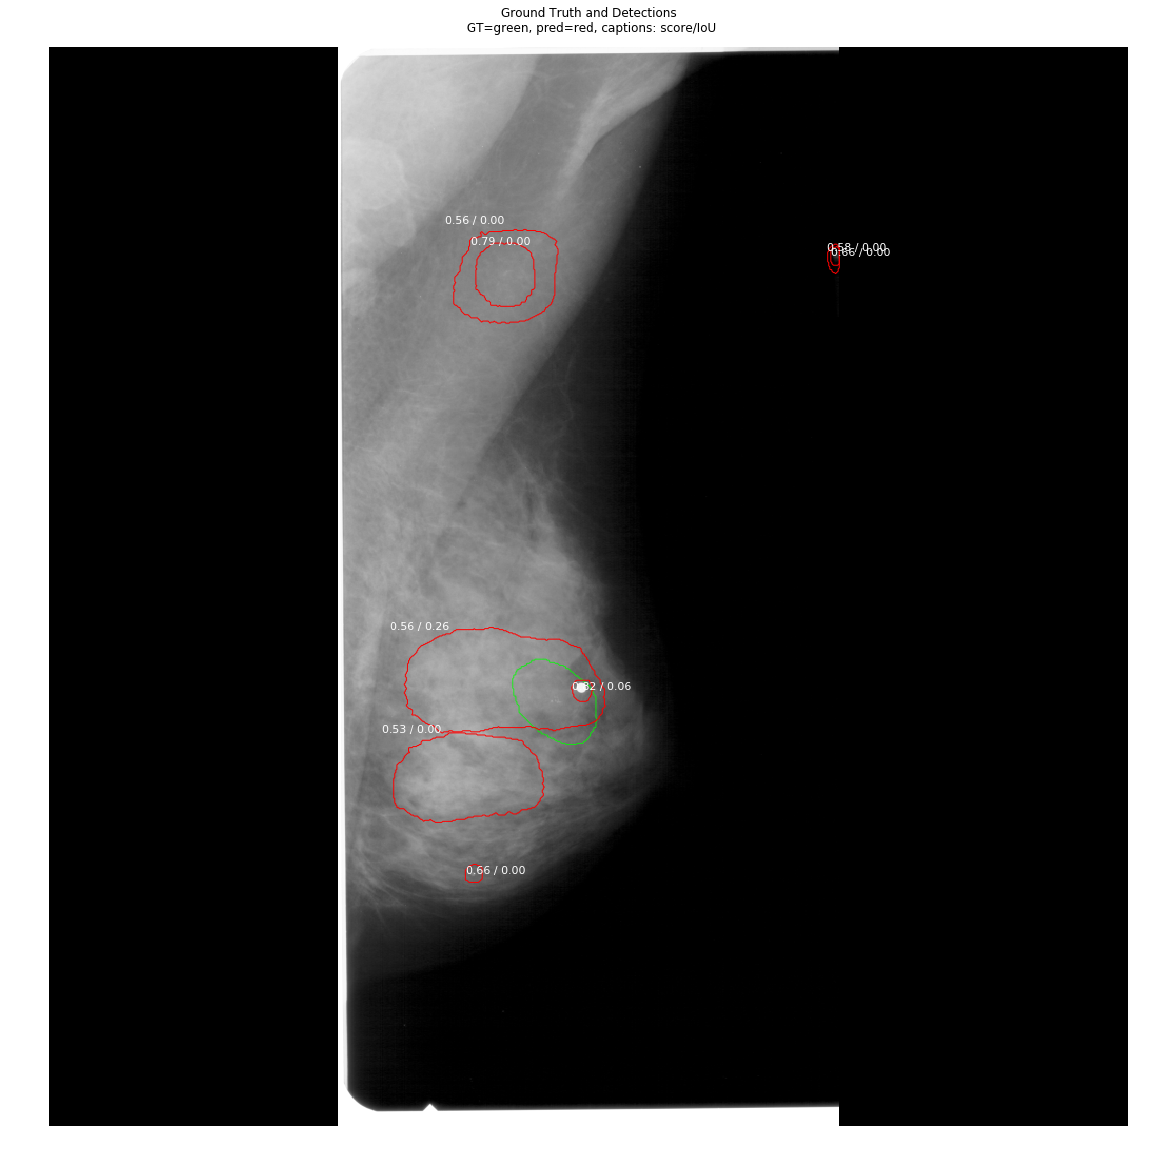

In [12]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [10]:
# Display predictions only
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset.class_names, r['scores'], ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Predictions")

In [11]:
# Display Ground Truth only
# visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset.class_names, ax=get_ax(1),
#                             show_bbox=False, show_mask=False,
#                             title="Ground Truth")

### Compute AP on Batch of Images

In [12]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [256 320   3]   AP: 0.41
  1 [256 320   3]   AP: 0.44
  2 [256 320   3]   AP: 0.69
  3 [1040 1388    3]   AP: 0.74
  4 [256 320   3]   AP: 0.33
Mean AP overa 5 images: 0.5215


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [28]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (196416, 4)           min: -181.00000  max: 1141.00000  int32
target_rpn_match         shape: (196416,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -2.10607  max:    2.37712  float64
positive_anchors         shape: (2, 4)                min:  344.00000  max:  685.00000  int32
negative_anchors         shape: (254, 4)              min:  -29.00000  max: 1020.00000  int32
neutral anchors          shape: (196160, 4)           min: -181.00000  max: 1141.00000  int32
refined_anchors          shape: (2, 4)                min:  352.00000  max:  691.00000  float32


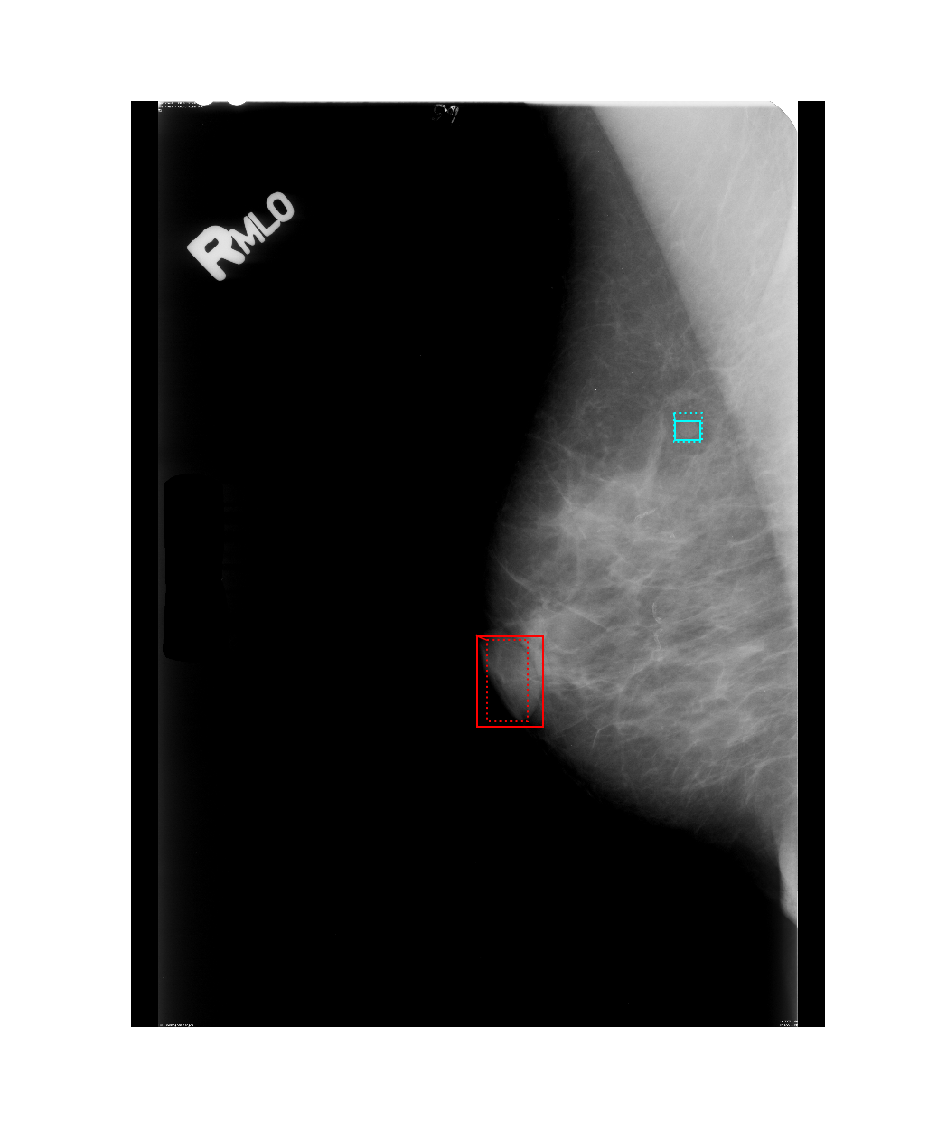

In [29]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [30]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 196416, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.23601  max:    1.15257  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.21701  max:    1.16766  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (3000,)               min:    0.00000  max: 5992.00000  int32
proposals                shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32


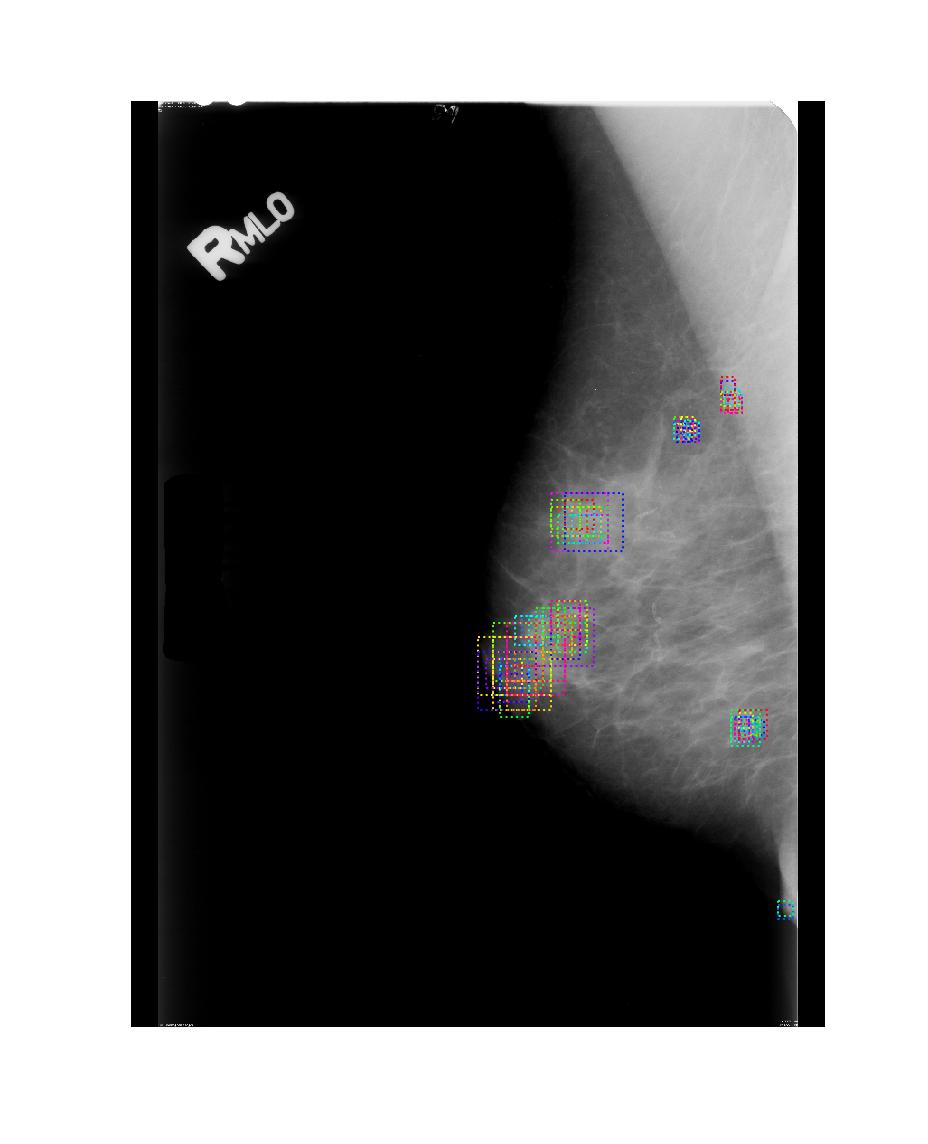

In [31]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [32]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 3000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 3000, 3, 4)       min:   -4.02729  max:    3.68013  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00208  max:    0.99998  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    2.00000  float32


4 detections: ['BENIGN' 'BENIGN' 'BENIGN' 'MALIGNANT']


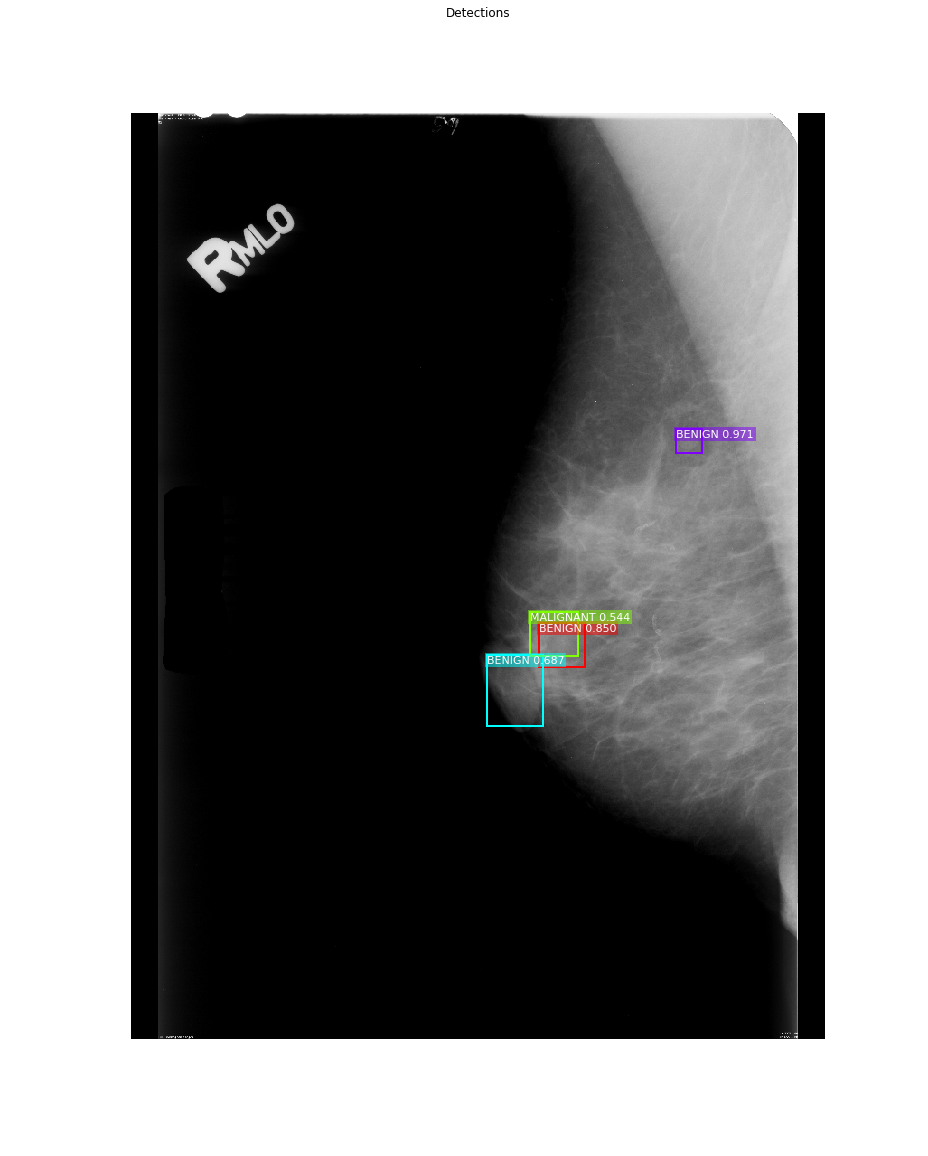

In [33]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [34]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

3000 Valid proposals out of 3000
91 Positive ROIs
[('BENIGN', 89), ('BG', 2909), ('MALIGNANT', 2)]


In [20]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

996 Valid proposals out of 3000
2 Positive ROIs
[('BG', 2998), ('mass', 2)]


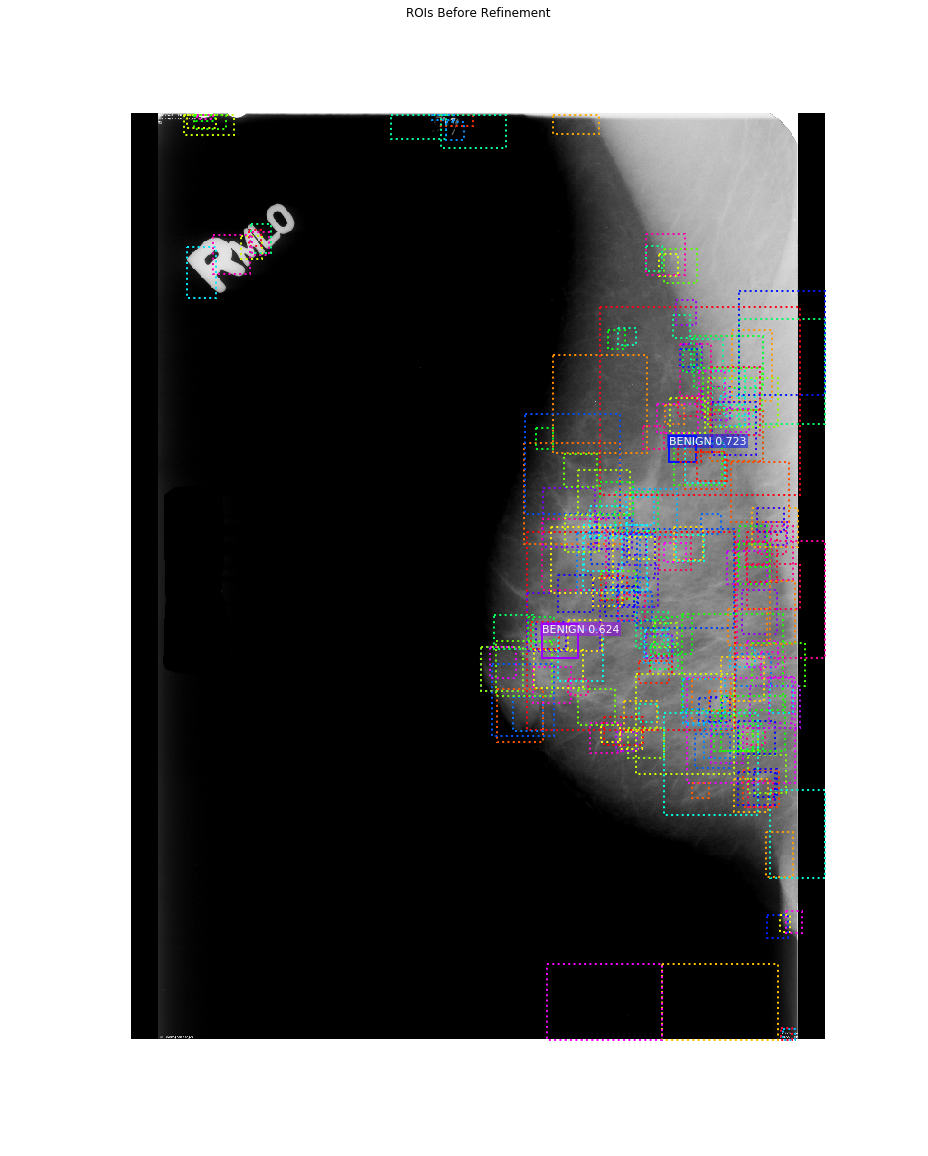

In [35]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (3000, 4)             min:   -3.81402  max:    2.69890  float32
refined_proposals        shape: (3000, 4)             min:   -0.00806  max:    1.02099  float32


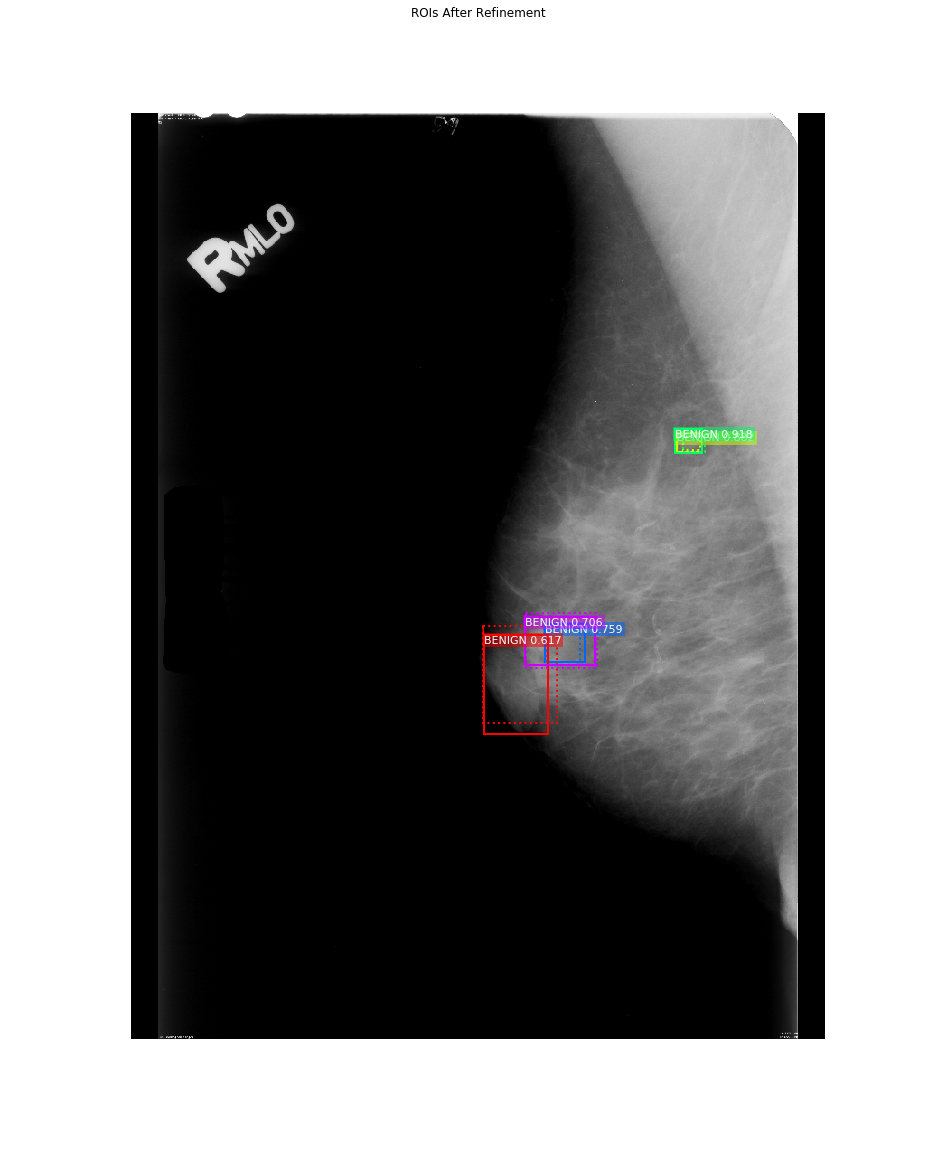

In [36]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [38]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 91 detections:
[   0    1    2    3    9   11   12   14   17   21   22   26   29   34
   46   55   56   58   78   88  103  113  114  148  156  168  181  202
  205  214  227  235  237  242  257  288  290  295  300  306  308  314
  320  345  361  379  419  422  423  433  446  449  458  489  524  531
  567  580  582  593  610  637  651  667  699  739  815  841  888  905
  966  976 1021 1078 1085 1112 1164 1177 1189 1199 1247 1271 1657 1790
 1816 1868 1904 1919 1932 2315 2565]


In [39]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 81:
[   0    1    2    3    9   11   12   14   17   21   22   26   29   34
   55   56   58   78   88  114  148  156  168  181  205  214  227  235
  237  242  257  288  290  300  306  308  314  320  345  361  379  419
  422  423  433  446  449  489  524  567  580  582  593  610  637  651
  667  699  739  815  841  888  905  966  976 1021 1078 1085 1112 1164
 1189 1199 1247 1271 1790 1816 1904 1919 1932 2315 2565]


#### Per-Class Non-Max Suppression

In [40]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

MALIGNANT             : [ 237 1085] -> [237]
BENIGN                : [   0    1    2    3    9   11   12   14   17   21   22   26   29   34
   55   56   58   78   88  114  148  156  168  181  205  214  227  235
  242  257  288  290  300  306  308  314  320  345  361  379  419  422
  423  433  446  449  489  524  567  580  582  593  610  637  651  667
  699  739  815  841  888  905  966  976 1021 1078 1112 1164 1189 1199
 1247 1271 1790 1816 1904 1919 1932 2315 2565] -> [  78  449 1247]

Kept after per-class NMS: 4
[  78  237  449 1247]


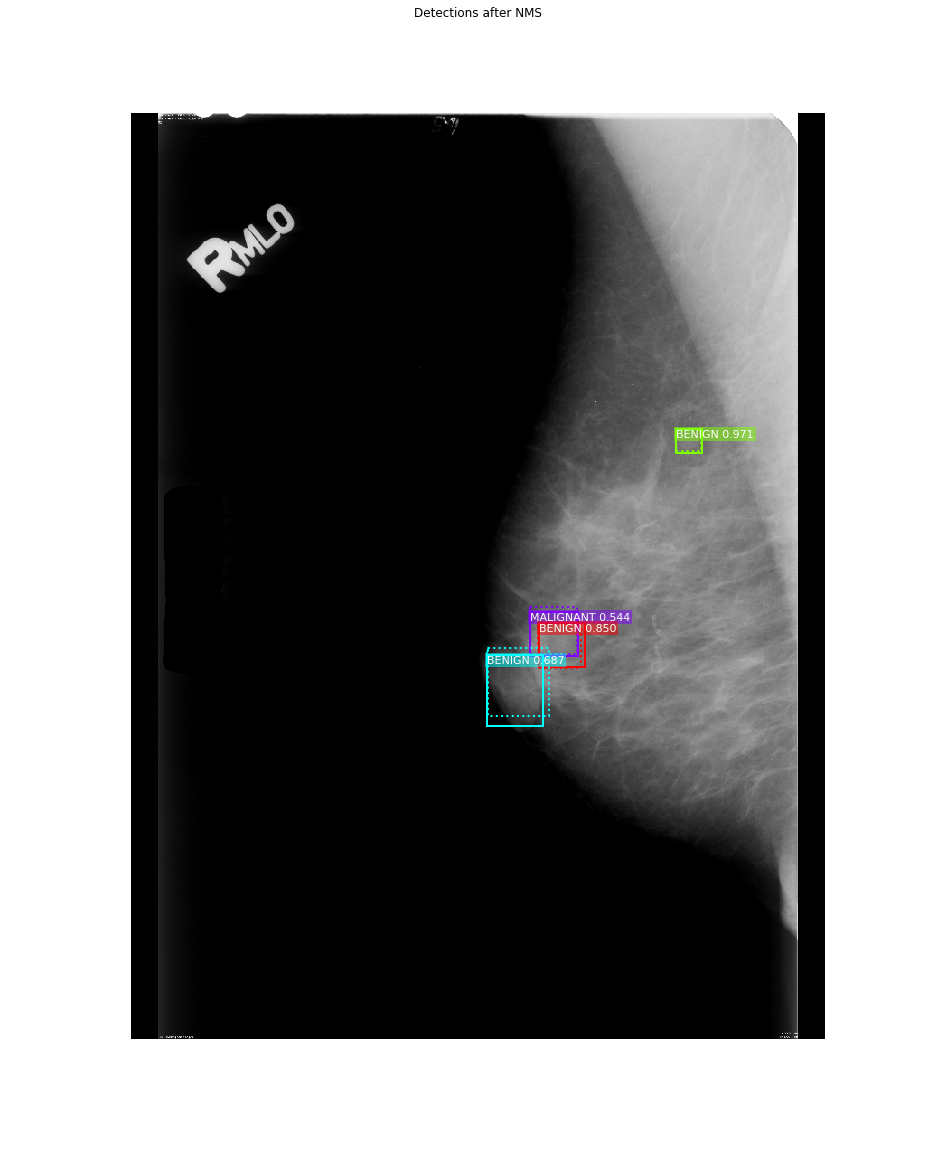

In [41]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

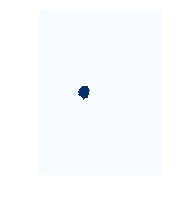

In [35]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [36]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00017  max:    1.00000  float32
6 detections: ['mass' 'mass' 'mass' 'mass' 'mass' 'mass']


In [37]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (6, 28, 28)           min:    0.00017  max:    1.00000  float32
det_masks                shape: (6, 1024, 768)        min:    0.00000  max:    1.00000  bool


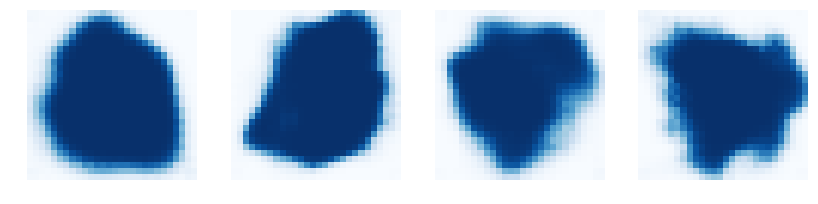

In [38]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

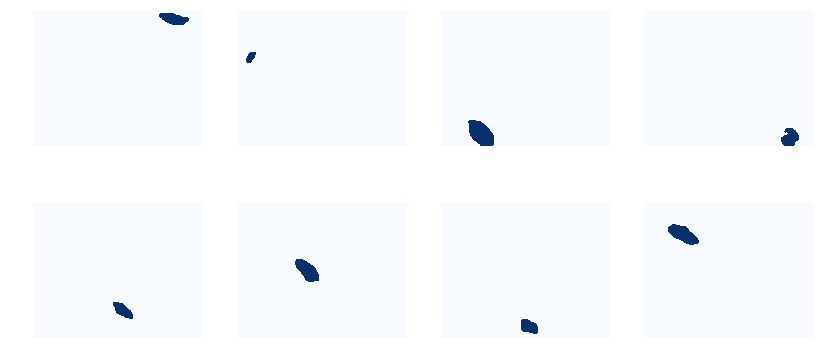

In [29]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

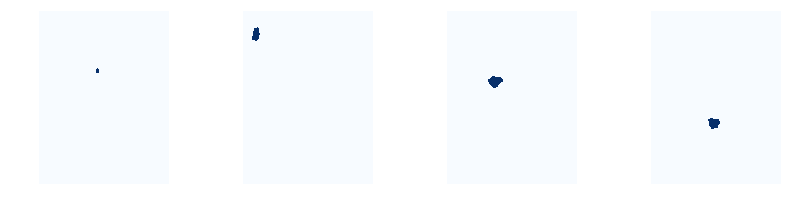

In [39]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [40]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 768, 3)     min:  -54.78000  max:  200.22000  float32
res2c_out                shape: (1, 256, 192, 256)    min:    0.00000  max:   18.20702  float32
res3c_out                shape: (1, 128, 96, 512)     min:    0.00000  max:   24.06776  float32
rpn_bbox                 shape: (1, 196416, 4)        min:  -12.87761  max:   36.05722  float32
roi                      shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32


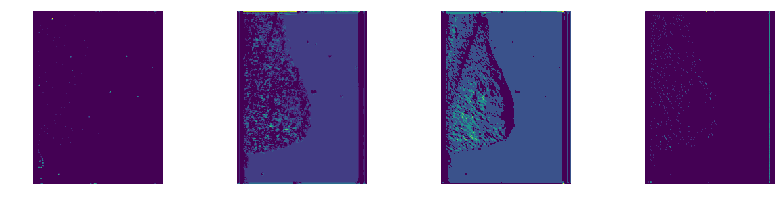

In [41]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [34]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1280, 3)    min:  -38.56000  max:  184.47000  float32
res2c_out                shape: (1, 256, 320, 256)    min:    0.00000  max:   18.96384  float32
res3c_out                shape: (1, 128, 160, 512)    min:    0.00000  max:   14.29902  float32
rpn_bbox                 shape: (1, 327360, 4)        min:  -14.41855  max:   60.67371  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


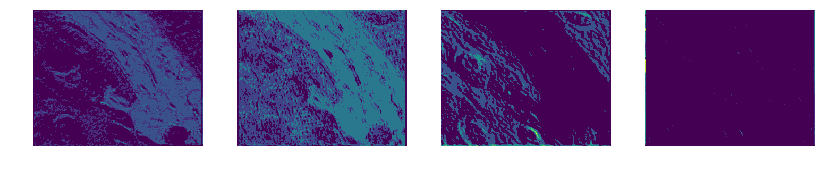

In [35]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)